Micrograd from Scratch

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install graphviz


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

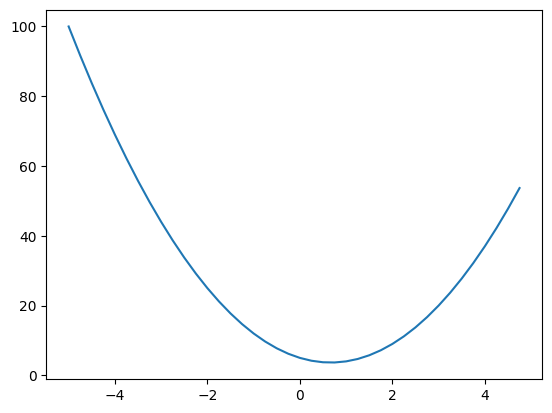

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [7]:
# Let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [9]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad +=  1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other): # other + self
        return self + other
        

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __truediv__(self, other): # self / other
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward()
        
        return out

    def backward(self):    
        topo = []
        visited = set()

        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
a = Value(2.0)
b = Value(4.0)
1 - a

Value(data=-1.0)

In [11]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this vale is a result for some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node or n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [12]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 * x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

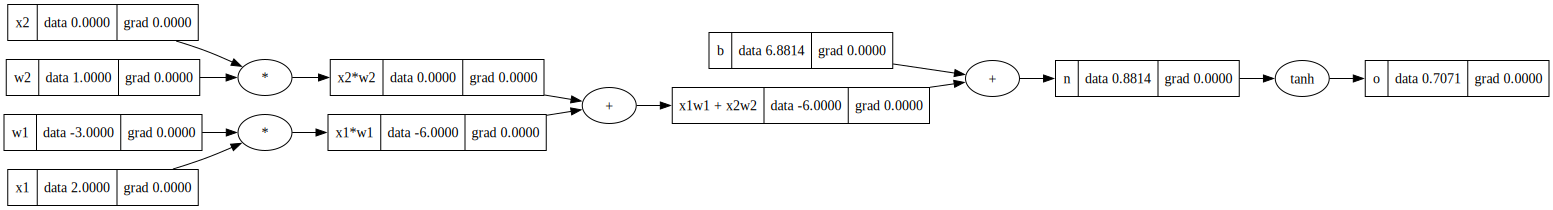

In [13]:
draw_dot(o)

In [14]:
o.backward()

In [15]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
        

In [16]:

n = MLP(3, [4, 4, 1])

In [17]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [51]:

for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05*p.grad

    print(k, loss.data)

0 0.0005874611197607721
1 0.0005869386840705463
2 0.000586417145895978
3 0.0005858965029537906
4 0.0005853767529684019
5 0.0005848578936718652
6 0.0005843399228038761
7 0.000583822838111721
8 0.0005833066373502436
9 0.0005827913182818181
10 0.0005822768786763153
11 0.0005817633163110725
12 0.0005812506289708726
13 0.0005807388144478768
14 0.0005802278705416581
15 0.0005797177950591
16 0.0005792085858144179
17 0.0005787002406290871
18 0.0005781927573318738
19 0.0005776861337587239
20 0.0005771803677528069
21 0.0005766754571644364
22 0.0005761713998510768
23 0.0005756681936772689
24 0.0005751658365146456
25 0.0005746643262418973
26 0.0005741636607447022
27 0.000573663837915746
28 0.0005731648556546597
29 0.0005726667118680187
30 0.0005721694044692871
31 0.0005716729313788184
32 0.0005711772905237808
33 0.0005706824798381925
34 0.0005701884972628455
35 0.0005696953407452907
36 0.0005692030082398229
37 0.0005687114977074253
38 0.0005682208071157786
39 0.0005677309344392176
40 0.00056724187

In [52]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9897594095044916),
 Value(data=-0.9847496083557491),
 Value(data=-0.9931374463311858),
 Value(data=0.9875589321924373)]